In [1]:
import pmdarima as pm
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error as MAE
from keras import regularizers
import statsmodels.api as sm
import seaborn as sns
from keras.layers import Dropout
import os
import glob
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

Using TensorFlow backend.


# Part 1: Data Gathering and Analysis

In [2]:
df=pd.read_csv("/Users/marcelo/Desktop/UC Berkeley/MFE 2019/MFE 230T/Bitcoin Project/dataset.csv")

In [67]:
df.head()

,Bitcoin Core (BTC) Price,Blockchain Size,Fee Rate,Hash Rate,Inflation Rate,Miner Revenue,Price Volatility,Total Transactions,Transaction Fees,Money Supply,Avg. UTXO Amount
Date,,,,,,,,,,,
2010-10-01,0.06,33861670,0,0.010555,35.8699,7300.000000,28.230596,123084,0.000000e+00,4150100.0,68.9855
2010-10-02,0.06,34034105,350,0.010511,35.8847,7700.560000,23.355039,123683,5.600000e-01,4157800.0,68.7512
2010-10-03,0.06,34218810,4,0.010098,35.8989,5000.007768,23.436625,124187,7.768130e-03,4162800.0,68.8624
2010-10-04,0.06,34326254,8,0.009904,35.9089,6100.007766,23.195348,124544,7.766250e-03,4168900.0,68.8335
2010-10-05,0.06,34468662,0,0.009845,35.8957,7650.000001,24.144686,124955,9.900000e-07,4176550.0,68.9700


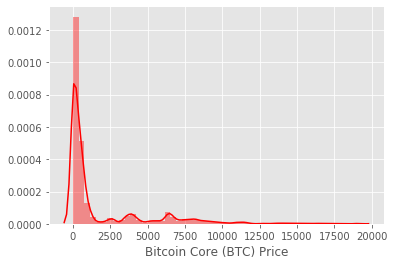

In [40]:
sns.distplot(df['Bitcoin Core (BTC) Price'],color="red")
plt.show()

In [5]:
df = df[(df['Date'] > '2010-1-1') & (df['Date'] <= '2019-06-30')]

In [6]:
df.isna().sum()

Date                          0
Bitcoin Core (BTC) Price      0
Blockchain Size               0
Fee Rate                      0
Hash Rate                     0
Inflation Rate              679
Miner Revenue                 0
Price Volatility            507
Total Transactions            0
Transaction Fees              0
Money Supply                  0
Avg. UTXO Amount              0
dtype: int64

In [7]:
df['Inflation Rate'].fillna(method='ffill', inplace=True)

In [8]:
df['Price Volatility'].fillna(method='ffill', inplace=True)


In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [10]:
df.dtypes

Bitcoin Core (BTC) Price    float64
Blockchain Size               int64
Fee Rate                      int64
Hash Rate                   float64
Inflation Rate              float64
Miner Revenue               float64
Price Volatility            float64
Total Transactions            int64
Transaction Fees            float64
Money Supply                float64
Avg. UTXO Amount            float64
dtype: object

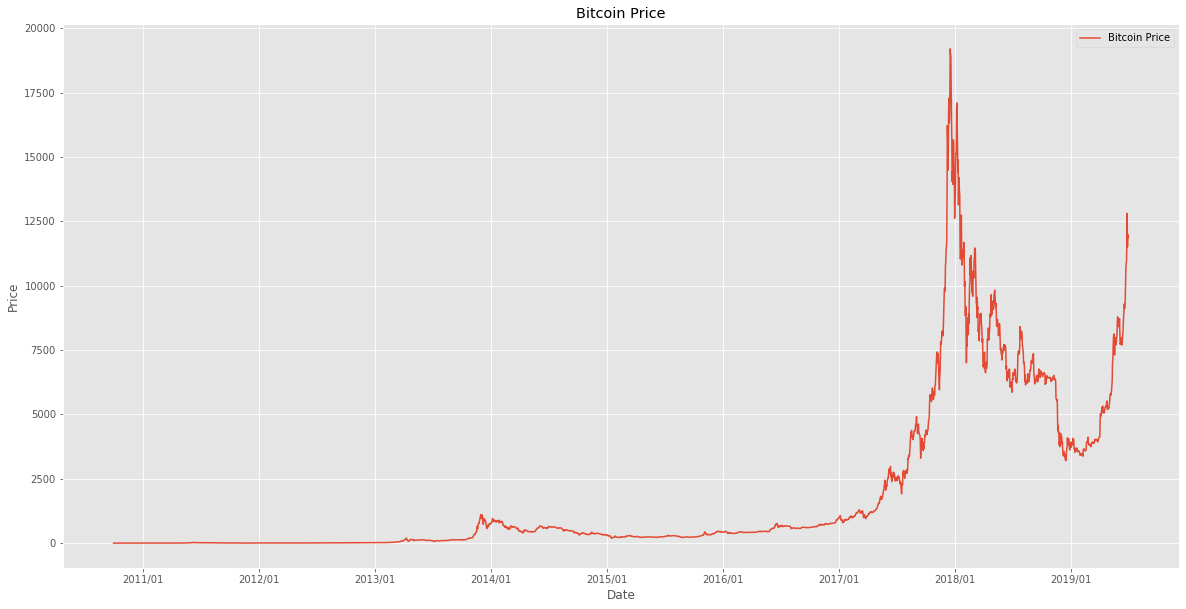

In [11]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

plt.style.use('ggplot')
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
date_form = DateFormatter("%Y/%m")
ax.xaxis.set_major_formatter(date_form)
plt.plot(df['Bitcoin Core (BTC) Price'])
plt.title('Bitcoin Price')
plt.legend(['Bitcoin Price'])
plt.xlabel('Date')
plt.ylabel('Price');
plt.show()

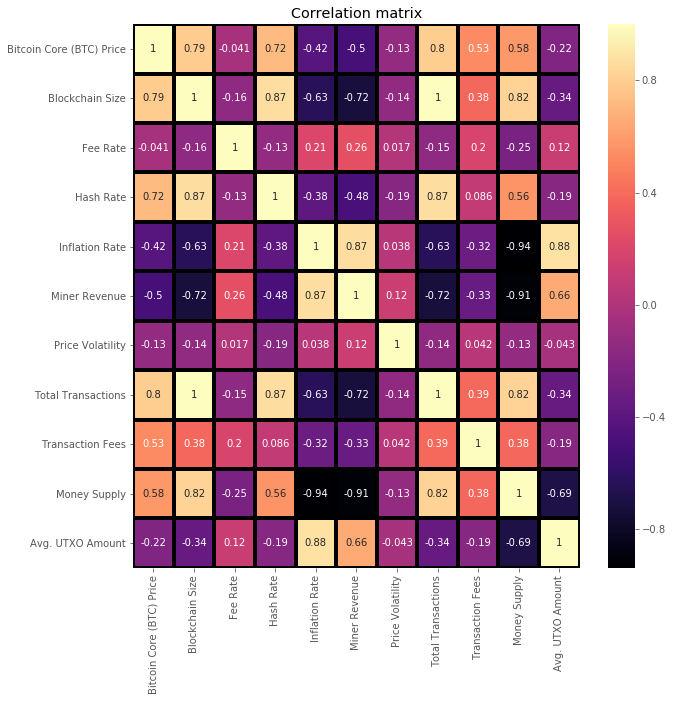

In [13]:
Var_Corr = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(Var_Corr ,xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns,annot=True,cmap='magma',linewidths=3, linecolor='black')

plt.title('Correlation matrix')
plt.show()

# Part 2: Data Pre-processing for Models

In [15]:
df=pd.read_csv("/Users/marcelo/Desktop/UC Berkeley/MFE 2019/MFE 230T/Bitcoin Project/dataset.csv")

In [16]:
df['Inflation Rate'].fillna(method='ffill', inplace=True)
df['Price Volatility'].fillna(method='ffill', inplace=True)

In [ ]:
#df['Bitcoin Core (BTC) Price']=np.log(df['Bitcoin Core (BTC) Price']+1)

In [17]:
df = df[(df['Date'] > '2010-1-1') & (df['Date'] <= '2019-06-30')]
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [18]:
split_date = '30-Jun-2018'
test_date ='01-Jan-2019'
df_train = df.loc[df.index <= split_date].copy()
df_validation = df.loc[(df.index > split_date) & (df.index < test_date)].copy()
df_test= df.loc[df.index >= test_date].copy()

In [19]:
price_train= df_train['Bitcoin Core (BTC) Price']
price_validation=df_validation['Bitcoin Core (BTC) Price']
price_test = df_test['Bitcoin Core (BTC) Price']
df_train=df_train.iloc[:,1:]
df_validation=df_validation.iloc[:,1:]
df_test=df_test.iloc[:,1:]

In [20]:
df_train.reset_index(drop=True,inplace=True)
df_validation.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

In [21]:
def lookback(data,data_y, lookback):
    X, Y = [], []
    for i in range(len(data) - lookback):
        a = data[i:(i + lookback), 0:] 
        X.append(a)
        Y.append(data_y[(i + lookback):(i+lookback+7)])
    return np.array(X), np.array(Y)

In [22]:
scaler = MinMaxScaler()
training_set = scaler.fit_transform(df_train)
validation_set = scaler.transform(df_validation)
test_set = scaler.transform(df_test) 

X_train, Y_train = lookback(training_set, price_train, lookback=28)
X_validation, Y_validation = lookback(validation_set, price_validation, lookback=28)
X_test, Y_test = lookback(test_set, price_test, lookback=28)

# Part 3: Build and Train Models

# 1a.

In [23]:
avg_benchmark=[]
for i in range(len(X_validation)):
    for ele in Y_validation[i]:
        avg_benchmark.append(np.mean(price_validation[i:28+i]))
    

In [24]:
print("MAE of using average of BTC prices of previous 28 days is",round(MAE(y_true=np.concatenate(Y_validation, axis=0),y_pred=avg_benchmark),6))

MAE of using average of BTC prices of previous 28 days is 539.057086


# 1b.

In [25]:
Last_benchmark=[]
for i in range(len(X_validation)):
    for ele in Y_validation[i]:
        Last_benchmark.append(price_validation[i+27])         

In [26]:
print("MAE of using most recent BTC price is",round(MAE(y_true=np.concatenate(Y_validation, axis=0),y_pred=Last_benchmark),6)) 

MAE of using most recent BTC price is 274.54591


# 2.

In [34]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Flatten
from keras import losses

In [35]:
batch_train = np.array([ np.array(training_set[i:28+i]) for i in range(len(training_set)-35)])
batch_train_price = np.array([ np.array(price_train[28+i:35+i]) for i in range(len(price_train)-35)])

batch_validation = np.array([ np.array(validation_set[i:28+i]) for i in range(len(validation_set)-35)])
batch_validation_price = np.array([ np.array(price_validation[28+i:35+i]) for i in range(len(price_validation)-35)])

In [36]:
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2795 samples, validate on 149 samples
Epoch 1/20
2795/2795 [==============================] - 2s 587us/step - loss: 1264.7238 - rmse: 1266.9822 - val_loss: 5168.3916 - val_rmse: 5173.2190
Epoch 2/20
2795/2795 [==============================] - 1s 180us/step - loss: 993.9756 - rmse: 997.1653 - val_loss: 3410.5336 - val_rmse: 3419.0671
Epoch 3/20
2795/2795 [==============================] - 0s 177us/step - loss: 894.7853 - rmse: 898.1540 - val_loss: 2155.2435 - val_rmse: 2174.5093
Epoch 4/20
2795/2795 [==============================] - 0s 170us/step - loss: 832.2589 - rmse: 836.0683 - val_loss: 1263.2997 - val_rmse: 1284.6524
Epoch 5/20
2795/2795 [==============================] - 1s 228us/step - loss: 754.3917 - rmse: 758.8183 - val_loss: 1191.7905 - val_rmse: 1214.1390
Epoch 6/20
2795/2795 [==============================] - 0s 170us/step - loss: 647.4141 - rm

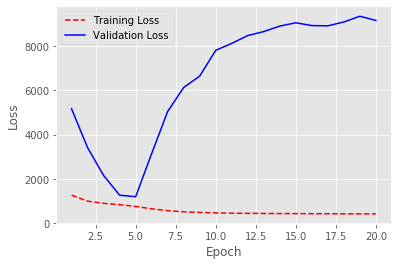

In [37]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

model = Sequential()
model.add(Flatten())
model.add(Dense(30,kernel_initializer='normal', activation = 'relu',input_shape=(28*10,)))
model.add(Dense(30,kernel_initializer='normal', activation = 'linear'))
model.add(Dense(7,kernel_initializer='normal'))

model.compile(optimizer = 'Adam', loss = 'mae', metrics = [rmse])
history = model.fit(batch_train, batch_train_price, epochs = 20, batch_size = 20,validation_data=(batch_validation, batch_validation_price))

results = model.evaluate(batch_train, batch_train_price)
print(results)
results = model.evaluate(batch_validation, batch_validation_price)
print(results)

training_loss = history.history['loss']
test_loss = history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [38]:
model.metrics_names

['loss', 'rmse']

Train on 2795 samples, validate on 149 samples
Epoch 1/10
2795/2795 [==============================] - 22s 8ms/step - loss: 1136.1558 - mean_absolute_error: 1136.1558 - rmse: 1174.2134 - val_loss: 5814.9742 - val_mean_absolute_error: 5814.9742 - val_rmse: 5819.0177
Epoch 2/10
2795/2795 [==============================] - 19s 7ms/step - loss: 1301.1026 - mean_absolute_error: 1301.1026 - rmse: 1303.2670 - val_loss: 5816.0161 - val_mean_absolute_error: 5816.0161 - val_rmse: 5820.0779
Epoch 3/10
2795/2795 [==============================] - 17s 6ms/step - loss: 1300.9709 - mean_absolute_error: 1300.9709 - rmse: 1303.1355 - val_loss: 5816.4130 - val_mean_absolute_error: 5816.4130 - val_rmse: 5820.4440
Epoch 4/10
2795/2795 [==============================] - 18s 6ms/step - loss: 1300.7933 - mean_absolute_error: 1300.7933 - rmse: 1302.9580 - val_loss: 5815.5768 - val_mean_absolute_error: 5815.5768 - val_rmse: 5819.6690
Epoch 5/10
2795/2795 [==============================] - 19s 7ms/step - loss: 

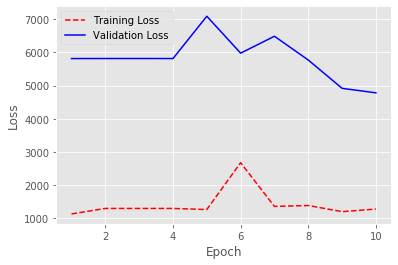

In [39]:
model = Sequential()
model.add(LSTM(32,return_sequences=True,kernel_initializer='normal',activation = 'relu'))
model.add(LSTM(7,return_sequences=False,kernel_initializer='normal',activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mae',rmse])
history = model.fit(batch_train, batch_train_price, epochs = 10, batch_size = 20,validation_data=(batch_validation, batch_validation_price))

results = model.evaluate(batch_train, batch_train_price)
print(results)
results = model.evaluate(batch_validation, batch_validation_price)
print(results)

training_loss = history.history['loss']
test_loss = history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Train on 2795 samples, validate on 149 samples
Epoch 1/10
2795/2795 [==============================] - 23s 8ms/step - loss: 841.7273 - mean_absolute_error: 841.7273 - rmse: 877.9629 - val_loss: 12705.1142 - val_mean_absolute_error: 12705.1142 - val_rmse: 12756.7932
Epoch 2/10
2795/2795 [==============================] - 18s 6ms/step - loss: 599.4289 - mean_absolute_error: 599.4289 - rmse: 607.0317 - val_loss: 11019.6971 - val_mean_absolute_error: 11019.6971 - val_rmse: 11025.8972
Epoch 3/10
2795/2795 [==============================] - 18s 6ms/step - loss: 621.6838 - mean_absolute_error: 621.6838 - rmse: 630.0223 - val_loss: 5817.6348 - val_mean_absolute_error: 5817.6348 - val_rmse: 5821.6772
Epoch 4/10
2795/2795 [==============================] - 18s 7ms/step - loss: 1301.0397 - mean_absolute_error: 1301.0397 - rmse: 1303.2008 - val_loss: 5821.4381 - val_mean_absolute_error: 5821.4381 - val_rmse: 5825.4760
Epoch 5/10
2795/2795 [==============================] - 18s 7ms/step - loss: 130

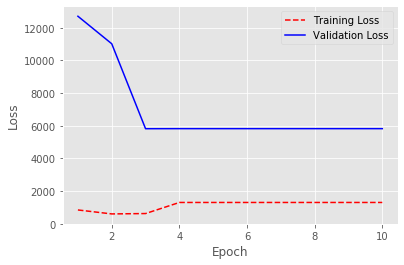

In [41]:
model = Sequential()
model.add(GRU(50,return_sequences = True,activation = 'linear'))
model.add(GRU(7, return_sequences = False,activation = 'linear'))
model.add(Activation('linear'))

model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mae',rmse])

history = model.fit(batch_train, batch_train_price, epochs = 10, batch_size = 20,validation_data=(batch_validation, batch_validation_price))

results = model.evaluate(batch_train, batch_train_price)
print(results)
results = model.evaluate(batch_validation, batch_validation_price)
print(results)

training_loss = history.history['loss']
test_loss = history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 2795 samples, validate on 149 samples
Epoch 1/10
2795/2795 [==============================] - 20s 7ms/step - loss: 1287.5581 - mean_absolute_error: 1287.5581 - rmse: 1292.8661 - val_loss: 5779.8578 - val_mean_absolute_error: 5779.8578 - val_rmse: 5784.0697
Epoch 2/10
2795/2795 [==============================] - 14s 5ms/step - loss: 1233.0074 - mean_absolute_error: 1233.0074 - rmse: 1250.5950 - val_loss: 5719.0374 - val_mean_absolute_error: 5719.0374 - val_rmse: 5723.3909
Epoch 3/10
2795/2795 [==============================] - 14s 5ms/step - loss: 1171.9263 - mean_absolute_error: 1171.9263 - rmse: 1196.6067 - val_loss: 5699.6733 - val_mean_absolute_error: 5699.6733 - val_rmse: 5704.1337
Epoch 4/10
2795/2795 [==============================] - 14s 5ms/step - loss: 1171.9234 - mean_absolute_error: 1171.9234 - rmse: 1194.5697 - val_loss: 5679.5638 - val_mean_absolute_e

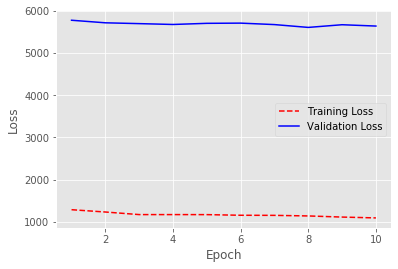

In [42]:
model = Sequential()
model.add(GRU(20,recurrent_dropout= 0.2,activation = 'relu',return_sequences=True))
model.add(GRU(7,activation = 'linear',return_sequences=False))

model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mae',rmse])
history = model.fit(batch_train, batch_train_price, epochs = 10, batch_size = 20,validation_data=(batch_validation, batch_validation_price))

results = model.evaluate(batch_train, batch_train_price)
print(results)
results = model.evaluate(batch_validation, batch_validation_price)
print(results)

training_loss = history.history['loss']
test_loss = history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Train on 2795 samples, validate on 149 samples
Epoch 1/20
2795/2795 [==============================] - 27s 9ms/step - loss: 1049.2000 - mean_absolute_error: 1049.2000 - rmse: 1114.3450 - val_loss: 7578.0420 - val_mean_absolute_error: 7578.0420 - val_rmse: 9208.6271
Epoch 2/20
2795/2795 [==============================] - 21s 7ms/step - loss: 884.2365 - mean_absolute_error: 884.2365 - rmse: 983.1217 - val_loss: 8501.3031 - val_mean_absolute_error: 8501.3031 - val_rmse: 9412.0196
Epoch 3/20
2795/2795 [==============================] - 20s 7ms/step - loss: 894.4181 - mean_absolute_error: 894.4181 - rmse: 989.8284 - val_loss: 8273.1775 - val_mean_absolute_error: 8273.1775 - val_rmse: 9087.3164
Epoch 4/20
2795/2795 [==============================] - 20s 7ms/step - loss: 818.9015 - mean_absolute_error: 818.9015 - rmse: 917.6306 - val_loss: 7388.4538 - val_mean_absolute_error: 7388.4538 - val_rmse: 8256.1208
Epoch 5/20
2795/2795 [==============================] - 20s 7ms/step - loss: 821.3749 

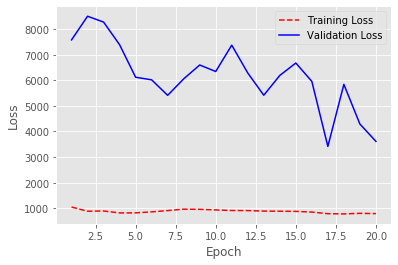

In [43]:
model = Sequential()

model.add(GRU(50,activation = 'linear',return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(7,recurrent_dropout= 0.2,activation = 'linear',return_sequences=False))
#model.add(GRU(7,activation = 'linear',return_sequences=False))


model.compile(optimizer = 'adam', loss = 'mae', metrics = ['mae',rmse])
history = model.fit(batch_train, batch_train_price, epochs = 20, batch_size = 20,validation_data=(batch_validation, batch_validation_price))

results = model.evaluate(batch_train, batch_train_price)
print(results)
results = model.evaluate(batch_validation, batch_validation_price)
print(results)

training_loss = history.history['loss']
test_loss = history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Bonus

# 7.

In [44]:
df = df.resample('D').mean()
df_month = df.resample('M').mean()
df_year = df.resample('A-DEC').mean()
df_quarterly = df.resample('Q-DEC').mean()

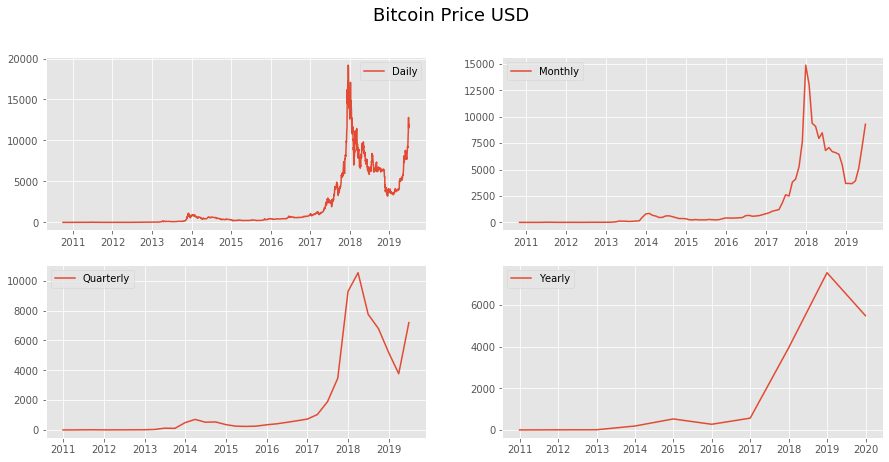

In [45]:
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin Price USD', fontsize=18)

plt.subplot(221)
plt.plot(df['Bitcoin Core (BTC) Price'], '-', label='Daily')
plt.legend()

plt.subplot(222)
plt.plot(df_month['Bitcoin Core (BTC) Price'], '-', label='Monthly')
plt.legend()

plt.subplot(223)
plt.plot(df_quarterly['Bitcoin Core (BTC) Price'], '-', label='Quarterly')
plt.legend()

plt.subplot(224)
plt.plot(df_year['Bitcoin Core (BTC) Price'], '-', label='Yearly')
plt.legend()

plt.show()


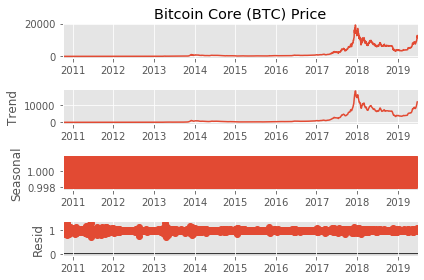

In [46]:
dec = sm.tsa.seasonal_decompose(df['Bitcoin Core (BTC) Price'],model='multiplicative')
decplot = dec.plot()

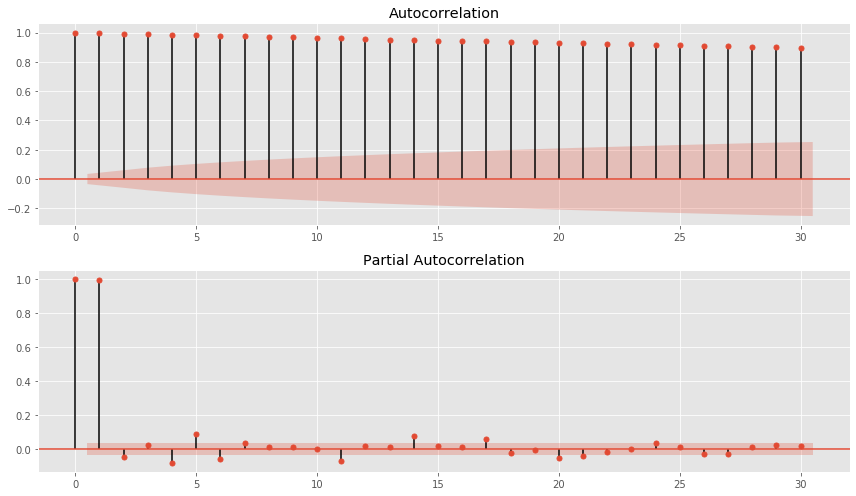

In [47]:
plt.figure(figsize=(12,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['Bitcoin Core (BTC) Price'], lags=30, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['Bitcoin Core (BTC) Price'], lags=30, ax=ax)
plt.tight_layout()
plt.show()

In [48]:
def DickeyFullerTest(series):
    testdf = adfuller(series)
    print("ADF Statistic : %.16f" %testdf[0] )
    print("DF test p-value : %.16f" %testdf[1] )
    

In [49]:
DickeyFullerTest(df['Bitcoin Core (BTC) Price'])

ADF Statistic : -0.5979482217487615
DF test p-value : 0.8714449710158605


p-value of Dickey-Fuller test <0.05, therefore the series is not stationary 
and we have to apply transformations in order to apply an ARIMA model

In [51]:
btc_log = np.log(df['Bitcoin Core (BTC) Price'])

In [52]:
DickeyFullerTest(btc_log)

ADF Statistic : -2.5165665843482610
DF test p-value : 0.1114953521196499


In [53]:
btc_log_shift = btc_log - btc_log.shift(1)
btc_log_shift.dropna(inplace = True)

In [54]:
DickeyFullerTest(btc_log_shift)

ADF Statistic : -12.3422318755132014
DF test p-value : 0.0000000000000000


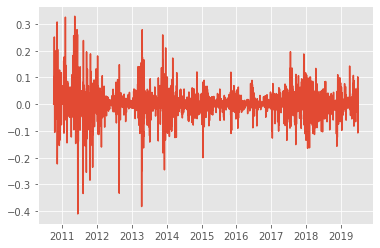

In [55]:
plt.plot(btc_log_shift)
plt.show()

Data is now stationary so we can apply ARIMA model

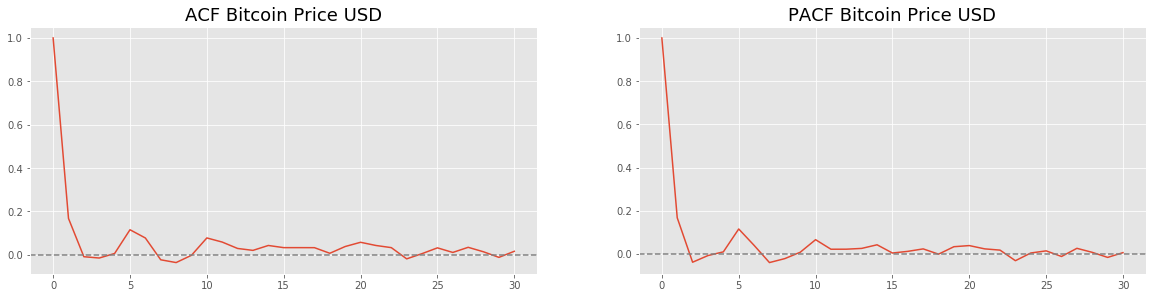

In [57]:
from statsmodels.tsa.stattools import acf, pacf
plt.figure(figsize = (20,10)) 
acf_plot = acf(btc_log_shift,nlags=30)
pacf_plot = pacf(btc_log_shift,nlags=30)

plt.subplot(221)
sns.lineplot(data=acf_plot)
plt.title('ACF Bitcoin Price USD', fontsize=18)
plt.axhline(y=0, linestyle='--', color='gray')

plt.subplot(222)
sns.lineplot(data=pacf_plot)
plt.title('PACF Bitcoin Price USD', fontsize=18)
plt.axhline(y=0, linestyle='--', color='gray')
plt.show()

In [58]:
aic_data = []
for p in range(5):
    for q in range(5):
        arima = ARIMA(
            endog=np.log(price_train),
            order=(p,1,q)
        )
        results = arima.fit()
        residuals = results.resid
        bic = results.bic
        aic = results.aic
        aic_data.append({'Num AR Terms': p, 'Num MA Terms': q, 'BIC': bic, 'AIC': aic})
        

ic_df = pd.DataFrame(aic_data).sort_values('AIC', ascending=True).reset_index()
best_ar = ic_df.loc[0, 'Num AR Terms']
best_ma = ic_df.loc[0, 'Num MA Terms']

In [59]:
ic_df

,index,Num AR Terms,Num MA Terms,BIC,AIC
0,24,4,4,-8973.417939,-9032.894725
1,17,3,2,-8966.307317,-9007.941067
2,22,4,2,-8960.193980,-9007.775409
3,13,2,3,-8965.079228,-9006.712978
4,18,3,3,-8958.883876,-9006.465304
5,23,4,3,-8952.745368,-9006.274475
6,19,3,4,-8952.096298,-9005.625406
7,14,2,4,-8957.554682,-9005.136110
8,21,4,1,-8961.001525,-9002.635275
9,16,3,1,-8963.351497,-8999.037569


In [60]:
model = ARIMA(np.log(price_train), order=(3,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                                 ARIMA Model Results                                  
Dep. Variable:     D.Bitcoin Core (BTC) Price   No. Observations:                 2829
Model:                         ARIMA(3, 1, 2)   Log Likelihood                4510.971
Method:                               css-mle   S.D. of innovations              0.049
Date:                        Wed, 01 Apr 2020   AIC                          -9007.941
Time:                                18:19:35   BIC                          -8966.307
Sample:                            10-02-2010   HQIC                         -8992.921
                                 - 06-30-2018                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.0041      0.001      3.853      0.000       0.002       0.006
a

<Figure size 1440x720 with 0 Axes>

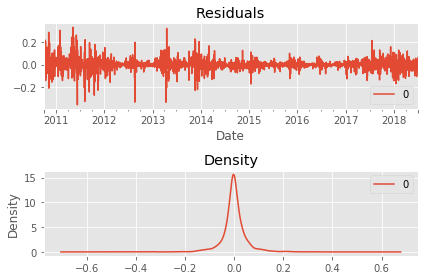

In [61]:
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize = (20,10)) 
fig, ax = plt.subplots(2,1)
residuals.plot(title="Residuals", ax=ax[0])
plt.legend("Residuals")
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()

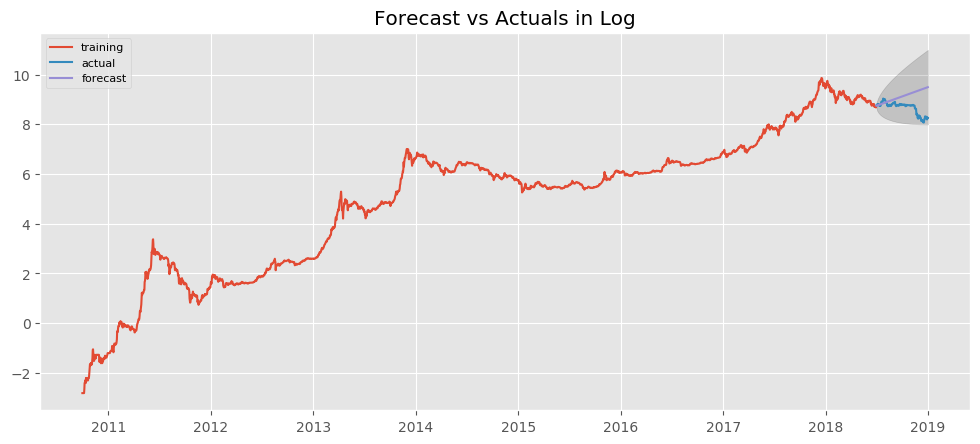

In [62]:
fc, se, conf = model_fit.forecast(184, alpha=0.05)  

fc_series = pd.Series(fc, index=price_validation.index)
lower_series = pd.Series(conf[:, 0], index=price_validation.index)
upper_series = pd.Series(conf[:, 1], index=price_validation.index)


plt.figure(figsize=(12,5), dpi=100)
plt.plot(np.log(price_train), label='training')
plt.plot(np.log(price_validation), label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals in Log')
plt.legend(loc='upper left', fontsize=8)
plt.show()

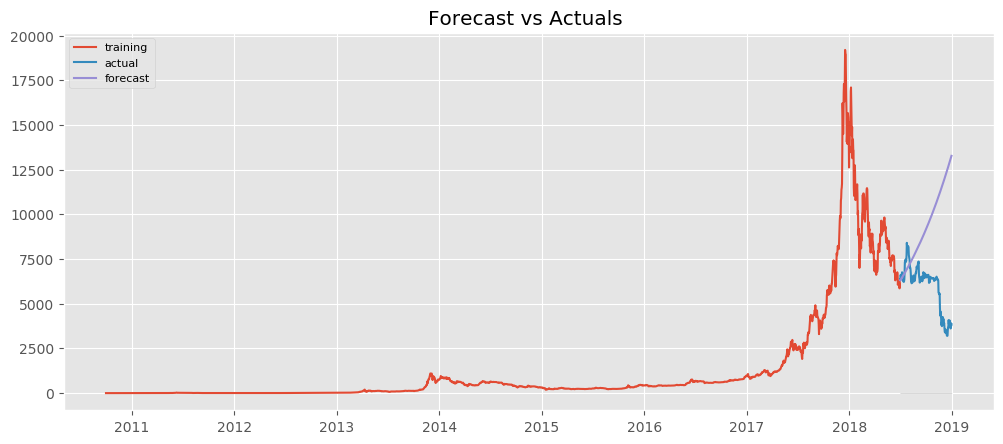

In [63]:
fc, se, conf = model_fit.forecast(184, alpha=0.05)  

fc_series = pd.Series(fc, index=price_validation.index)
lower_series = pd.Series(conf[:, 0], index=price_validation.index)
upper_series = pd.Series(conf[:, 1], index=price_validation.index)


plt.figure(figsize=(12,5), dpi=100)
plt.plot(price_train, label='training')
plt.plot(price_validation, label='actual')
plt.plot(np.exp(fc_series), label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals ')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [64]:
def forecast_accuracy(forecast, actual):
   
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  
  
    return({'MAE': mae, 'RMSE':rmse,  })

forecast_accuracy(fc, price_validation.values)

{'MAE': 5983.324448583729, 'RMSE': 6119.0689043516095}